In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.manifold import Isomap
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import offsetbox
%matplotlib inline

In [3]:
#ouverture des array d'image
from numpy import load

np.load.__defaults__=(None, True, True, 'ASCII')

X_brain= load('/content/drive/My Drive/Colab_outputs/X_brain_256.npy')
y_brain = load('/content/drive/My Drive/Colab_outputs/y_brain.npy')


On prend les données en 256x256 car ce sont sur ces données que l'on execute les modèles de transfer leraning pour la classification et Unet pour la segmentation. L'intérêt est de voir, si nous pouvons aller encore plus loin en optimisant les temps de calcul par la réduction des dimensions, ce qui est très utilisé en imagerie, puisque chaque observation contient 65 536 features. 

In [4]:
#############################
### reduction de dimension ##
#############################


def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)


In [5]:
X_brain.shape

(2501, 256, 256, 3)

In [6]:
a = X_brain[...,0]
#ou means avec -1
#X_brain_reshaped = a.reshape(-1,650*650)
#X_brain_reshaped.shape
data = a.reshape(-1,256*256)
data.shape

(2501, 65536)

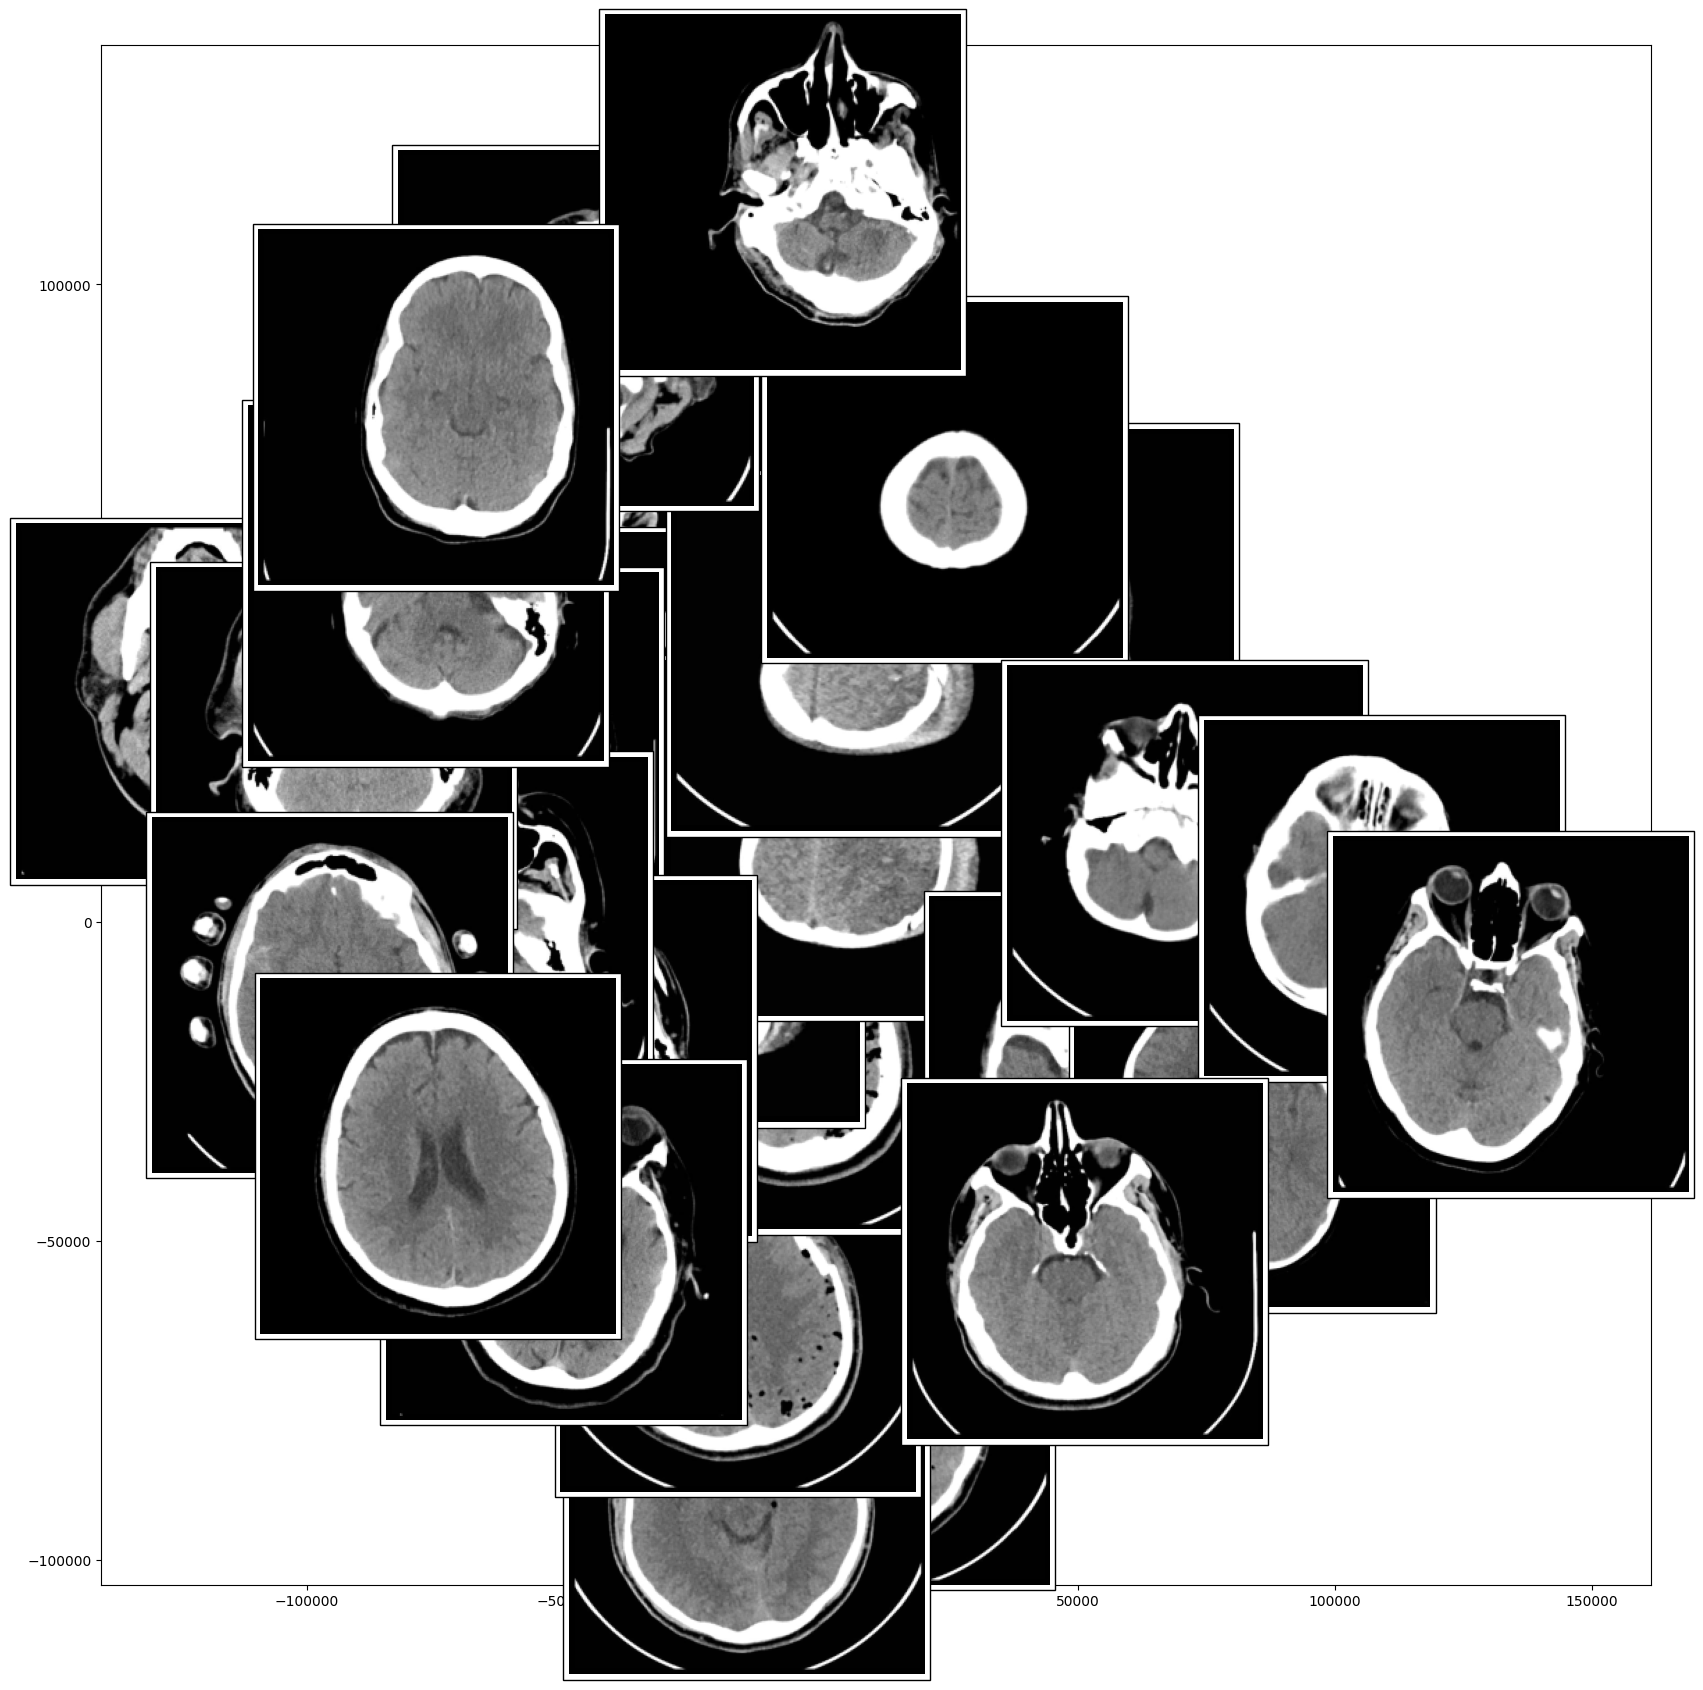

In [7]:
fig, ax = plt.subplots(figsize=(20, 20))

#identification des facteurs de variance sur les radios d'hemorragie

plot_components(data,
                model=Isomap(n_components=2),
                images=data.reshape((-1, 256, 256)),
                cmap = 'gray',
                thumb_frac = .1)

Nous allons maintenant réduire la dimension de notre jeu de données en supprimant les pixels qui apportent le moins d'informations. Ainsi le modèle ne s'entrainera pas sur des pixels inutiles.

In [8]:
#on split les données

X_train, X_test, y_train, y_test = train_test_split(data, y_brain, test_size = .2, random_state = 42, shuffle = True)

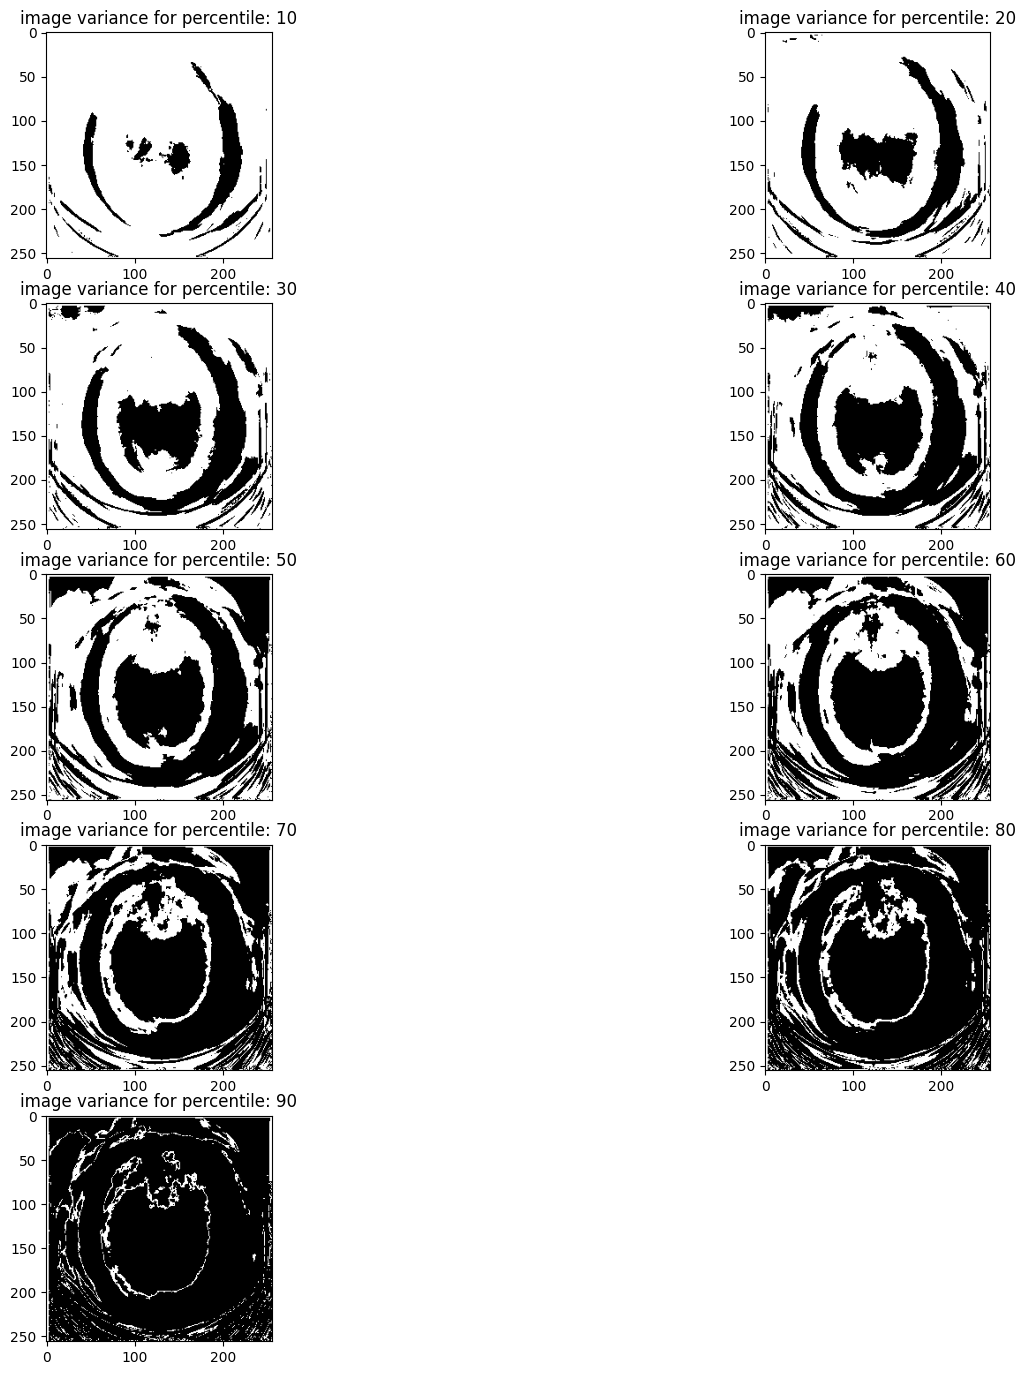

In [9]:
# selection par le percentile

import warnings
warnings.filterwarnings("ignore")

list_percentile = np.arange(10, 100, 10).tolist()

fig = plt.figure(figsize = (17,17))

for index, i in enumerate(list_percentile):

    sel = SelectPercentile(percentile = i)
    sel.fit(X_train, y_train)

    X_train_red = sel.transform(X_train)
    X_test_red = sel.transform(X_test)

    fig.add_subplot(5,2,index+1)
    
    plt.title('image variance for percentile: ' + str(i))
    plt.imshow(sel.get_support().reshape(256,256), cmap = 'gray_r');

Prenons le percentile 90 pour garder le maximum d'information. Les pixels apportant le moins d'information sont ceux représentés en blanc. Nous préférons une première approche qui minimise le risque de supprimer de l'information essentielle.

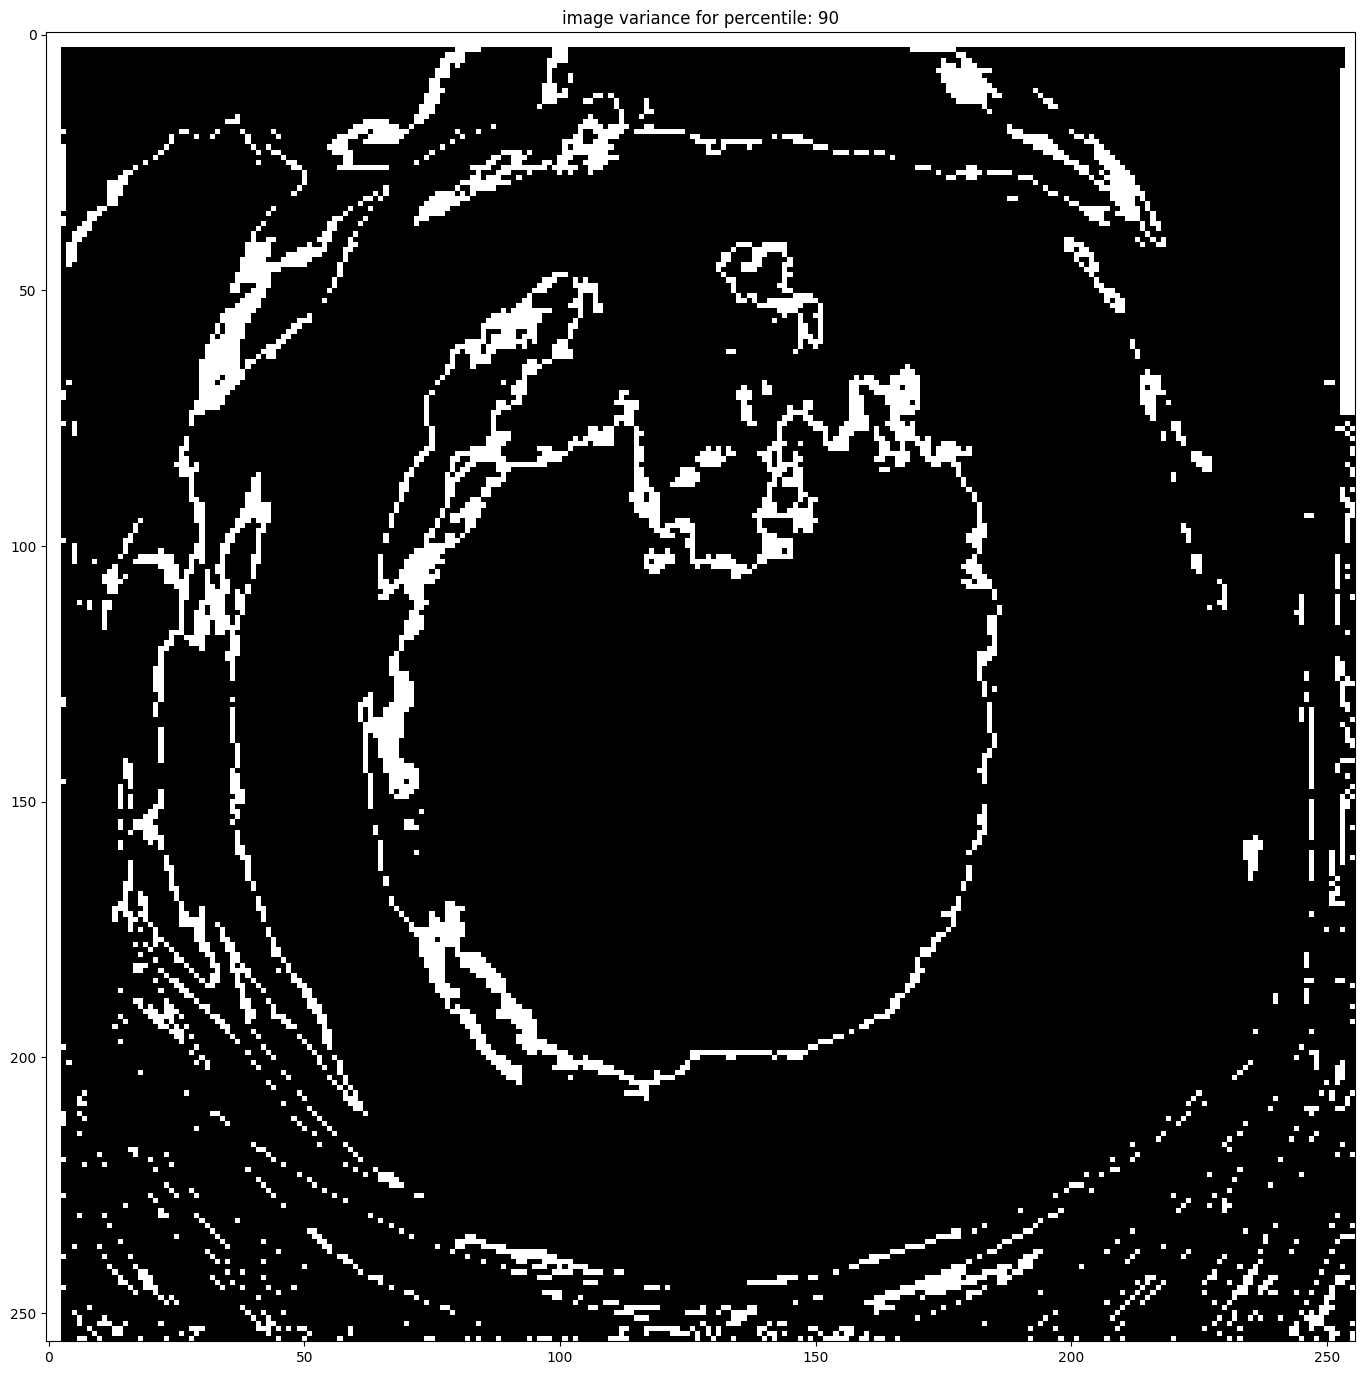

In [10]:
# on va prendre le percentile 90 et voir ce que cela donne en représentation d'image par la suite

import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(figsize = (17,17))

sel = SelectPercentile(percentile = 90)
sel.fit(X_train, y_train)

X_train_red = sel.transform(X_train)
X_test_red = sel.transform(X_test)
    
plt.title('image variance for percentile: 90')
plt.imshow(sel.get_support().reshape(256,256), cmap = 'gray_r');

In [11]:
# fonction qui affiche l'image avec les pixel inutiles selon le selecteur choisi

def plot_reduced_image(image, selector):
    mask = selector.get_support()
    #toprint = [image[i] if mask[i] == True else 0 for i in range(sum(mask))]
    fullimg = np.array([])
    cnt = 0
    for i in range(256*256):
        if mask[i]:
            fullimg = np.append(fullimg, image[i-cnt])
        else:
            fullimg = np.append(fullimg, 0)
            cnt += 1
    plt.imshow(fullimg.reshape(256,256), cmap = 'gray')

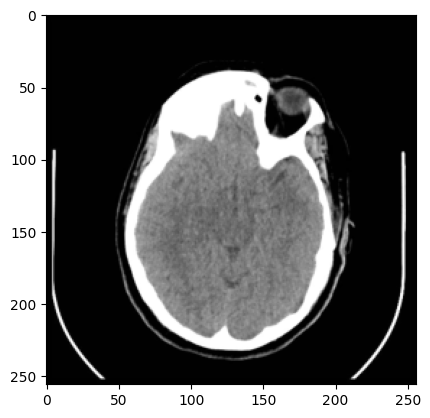

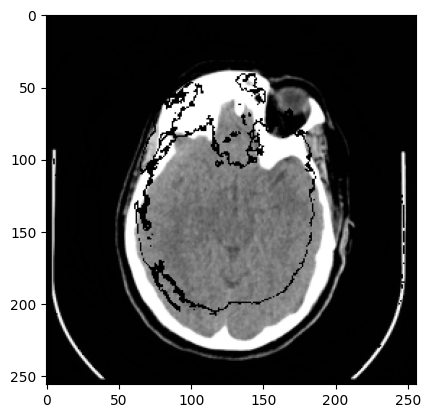

In [12]:
# affichage pour selecteur SelectPercentile

plt.figure()
plt.imshow(X_train[3].reshape(256,256), cmap = 'gray')
plt.show();
plot_reduced_image(X_train_red[3], sel)

La thomographie du cerveau est toujours reconnaissable aisément, comme attendu.

In [13]:
X_train_red.shape

(2000, 58982)

La première réduction est plutôt minime car on passe de 65 536 à 58 982 features, ce qui est encore très conséquent pour une observation.

In [14]:
#appliquons une lda sur les données réduites suite à select Percentile

lda = LDA()
X_train_lda = lda.fit_transform(X_train_red, y_train)
X_test_lda = lda.transform(X_test_red)

X_train_lda.shape

(2000, 1)

On est passé de 58 982 features à 1 seule ! On est en droit de ce demander si l'information retranscrite a toujours du sens.

In [15]:
#test de la performances avec un classifieur - Select Percentile + LDA

svc = SVC(C = 1, kernel = 'linear')
svc.fit(X_train_lda, y_train)
print("Score on reduced data :", svc.score(X_test_lda, y_test))
svc.fit(X_train, y_train)
print("Score on full data :", svc.score(X_test, y_test))

#les score a été un peu dégradé en minimisant les dimensions mais mieux qu'avec PCA

Score on reduced data : 0.9321357285429142
Score on full data : 0.9500998003992016


La réduction des données réalisée par le select Percentile, suivi du LDA donne de très bons résultats de performance sur le classifieur (SVM); le score de précision des données réduite est très correct par rapport au score réalisé sur les données initiales (features de 256x256). Cela est tout de même très étrange vu l'information importante que l'on perd... il faudrait creuser un peu plus cette problématique.

In [16]:
### sauvegarde des données réduites pour faire tourner les modèles de machine learning (classification) et voir les résultats

np.save('/content/drive/My Drive/Colab_outputs/X_train_reduced_256.npy', X_train_lda)
np.save('/content/drive/My Drive/Colab_outputs/y_train_reduced_256.npy', y_train)
np.save('/content/drive/My Drive/Colab_outputs/X_test_reduced_256.npy', X_test_lda)
np.save('/content/drive/My Drive/Colab_outputs/y_test_reduced_256.npy', y_test)

Globalement, la classe d'une image est déterminée par une nombre (ou indice)

In [17]:
print(X_train_lda)

[[-1.84808587]
 [-1.59405594]
 [-0.83968881]
 ...
 [ 6.01259792]
 [ 0.70290158]
 [-0.7516624 ]]
